In [1]:
import asyncio
import aiohttp
import aiomoex
import pandas as pd
from datetime import datetime, timedelta
import sqlite3
import nest_asyncio
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from matplotlib.dates import AutoDateLocator, DateFormatter, MonthLocator


warnings.filterwarnings("ignore")

nest_asyncio.apply()

class MoexDataRetrival():
    
    def __init__(self, start_date : str, end_date : str):
        self.start_date = start_date
        self.end_date = end_date

    #get a stock list from MOEX exchange
    async def get_stock_list(self) -> pd.DataFrame:
        request_url = "https://iss.moex.com/iss/engines/stock/" "markets/shares/boards/TQBR/securities.json"
        arguments = {
            "securities.columns": (
                "SECID,"
                "REGNUMBER,"
                "LOTSIZE,"
                "SHORTNAME,"
                "BOARDID,"
                "LISTLEVEL,"
                "ISIN,"
                "ISSUECAPITALIZATION,"
                "FACEVALUE,"
                "ISSUESIZE,"
            )
        }
        async with aiohttp.ClientSession() as session:
            iss = aiomoex.ISSClient(session, request_url, arguments)
            data = await iss.get()
            data = pd.DataFrame(data["securities"])
            return data['SECID']

    #get a stock list from MOEX exchange
    async def get_stock_list_with_extra_data(self) -> pd.DataFrame:
        request_url = "https://iss.moex.com/iss/engines/stock/" "markets/shares/boards/TQBR/securities.json"
        arguments = {
            "securities.columns": (
                "SECID,"
                "REGNUMBER,"
                "LOTSIZE,"
                "SHORTNAME,"
                "BOARDID,"
                "LISTLEVEL,"
                "ISIN,"
                "ISSUECAPITALIZATION,"
                "FACEVALUE,"
                "ISSUESIZE,"
            )
        }
        async with aiohttp.ClientSession() as session:
            iss = aiomoex.ISSClient(session, request_url, arguments)
            data = await iss.get()
            data = pd.DataFrame(data["securities"])
            return data

    #get a price history for the ticker in TQBR regime  
    
    async def get_price_history(self, ticker : str) -> pd.DataFrame:
        async with aiohttp.ClientSession() as session:
            columns=[
                    "BOARDID", "TRADEDATE", "SHORTNAME", "SECID", "NUMTRADES",
                    "VALUE", "OPEN", "LOW", "HIGH", "LEGALCLOSEPRICE",
                    "WAPRICE", "CLOSE", "VOLUME", "MARKETPRICE2", "MARKETPRICE3",
                    "ADMITTEDQUOTE", "MP2VALTRD", "MARKETPRICE3TRADESVALUE",
                    "ADMITTEDVALUE", "WAVAL"
                ]
            data = await aiomoex.get_board_history(session, ticker,columns = columns,start = self.start_date, end = self.end_date)
            df = pd.DataFrame(data)
            return df

    #get a price history for the ticker in TQBR regime  
    async def get_multiple_price_histories(self, tickers : pd.Series) -> pd.DataFrame:
        tasks = [self.get_price_history(ticker) for ticker in tickers]
        results = await asyncio.gather(*tasks)
        combined_df = pd.concat(results, ignore_index=True)
        combined_df['TRADEDATE'] = pd.to_datetime(combined_df['TRADEDATE'])
        condition = (combined_df['SECID'] == 'GMKN') & (combined_df['TRADEDATE'] <= '2024-04-01')
        combined_df.loc[condition, 'CLOSE'] = combined_df.loc[condition, 'CLOSE'] / 100
        condition = (combined_df['SECID'] == 'TRNFP') & (combined_df['TRADEDATE'] <= '2024-02-14')
        combined_df.loc[condition, 'CLOSE'] = combined_df.loc[condition, 'CLOSE'] / 100
        return combined_df


    #check the stocks which are trading near min for the last n years
    def get_tickers_which_we_can_buy_now(self, df : pd.DataFrame, years : int, percent : float):

        # Ensure TRADEDATE is in datetime format
        df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
        # Calculate date n years ago
        today = datetime.now()
        n_years_ago = today - timedelta(days=years*365)

        # Filter data for the last n years
        df_last_n_years = df[df['TRADEDATE'] >= n_years_ago]

        # Calculate the minimum and maximum closing price for each ticker over the last 2 years
        min_prices = df_last_n_years.groupby('SECID')['CLOSE'].min().reset_index()
        min_prices.rename(columns={'CLOSE': 'MIN_CLOSE'}, inplace=True)
        max_prices = df_last_n_years.groupby('SECID')['CLOSE'].max().reset_index()
        max_prices.rename(columns={'CLOSE': 'MAX_CLOSE'}, inplace=True)

        # Get the latest closing price for each ticker
        latest_prices = df_last_n_years.sort_values('TRADEDATE').groupby('SECID').tail(1).reset_index()
        latest_prices = latest_prices[['SECID', 'CLOSE']].rename(columns={'CLOSE': 'LATEST_CLOSE'})

        # Merge the minimum, maximum, and latest prices
        merged_df = pd.merge(min_prices, max_prices, on='SECID')
        merged_df = pd.merge(merged_df, latest_prices, on='SECID')

        # Filter tickers where the latest closing price is not higher than x% above the minimum price
        condition = merged_df['LATEST_CLOSE'] <= merged_df['MIN_CLOSE'] * (1+percent/100)
        result = merged_df[condition]

        return result
    
    
class BiddingResultsDBLoader():
    
    #main table name - это название основной таблицы где лежат итоги торгов
    def __init__(self, path_to_db : str, main_table_name : str):
        
        self.path_to_db = path_to_db
        self.main_table_name = main_table_name
        
    #remove duplicates from table
    def remove_duplicates(self):
        """
        Connects to an SQLite database and removes duplicate rows from the specified table.

        Parameters:
        database_path (str): The path to the SQLite database file.
        table_name (str): The name of the table from which to remove duplicates.
        """
        # Connect to the SQLite database
        conn = sqlite3.connect(self.path_to_db)
        cursor = conn.cursor()

        # Define the query to remove duplicates
        delete_duplicates_query = f"""
        WITH duplicates AS (
            SELECT 
                ROWID,
                BOARDID,
                TRADEDATE,
                CLOSE,
                VOLUME,
                VALUE,
                SECID,
                ROW_NUMBER() OVER (PARTITION BY BOARDID, TRADEDATE, SECID ORDER BY ROWID) AS rn
            FROM 
                {self.main_table_name}
        )
        DELETE FROM {self.main_table_name}
        WHERE ROWID IN (
            SELECT ROWID
            FROM duplicates
            WHERE rn > 1
        );
        """

        try:
            # Execute the query to delete duplicates
            cursor.execute(delete_duplicates_query)
            # Commit the transaction
            conn.commit()
        except sqlite3.Error as error:
            print(f"Error while removing duplicates: {error}")
        finally:
            # Close the connection
            conn.close()



    def insert_data_to_database(self, df : pd.DataFrame):
        conn = sqlite3.connect(self.path_to_db)
        df.to_sql(self.main_table_name, conn, if_exists='append', index=False)
        self.remove_duplicates()
        conn.close()
        
    def GetBiddindTableData(self) -> pd.DataFrame:
        conn = sqlite3.connect(self.path_to_db)
        query = "SELECT * FROM " + self.main_table_name
        bidding_data = pd.read_sql_query(query, conn)
        conn.close()
        return bidding_data
    
    def GetDeals(self) -> pd.DataFrame:
        conn = sqlite3.connect(self.path_to_db)
        query = "SELECT * FROM DEALS"
        deals = pd.read_sql_query(query, conn)
        conn.close()
        return deals
    
    def GetDataForReturns(self) -> pd.DataFrame:
        conn = sqlite3.connect(self.path_to_db)
        query = f"""WITH joined_data AS (
    SELECT 
        m.TRADEDATE,
        m.SECID,
        m.CLOSE,
        COALESCE(d.DEVIDEND,0) DEVIDEND,
        CASE
            WHEN d.DIRECTION <> 'BUY'  THEN COALESCE(-d.NUMBER_OF_SHARES,0)
            ELSE COALESCE(d.NUMBER_OF_SHARES,0)
        END AS NUMBER_OF_SHARES,
        
        CASE
            WHEN d.DIRECTION <> 'SELL'  THEN COALESCE(-d.TOTAL_VOLUME,0) - COALESCE(d.BROKER_COMMISSIONS,0) - COALESCE(d.EXCHANGE_COMMISSIONS,0) + COALESCE(d.DEVIDEND,0)
            ELSE COALESCE(d.TOTAL_VOLUME,0) - COALESCE(d.EXCHANGE_COMMISSIONS,0) + COALESCE(d.DEVIDEND,0)
        END AS TOTAL_VOLUME,
        COALESCE(-d.BROKER_COMMISSIONS,0) BROKER_COMMISSIONS,
        COALESCE(-d.EXCHANGE_COMMISSIONS,0) EXCHANGE_COMMISSIONS
        
    FROM 
        moexdata m
    LEFT JOIN 
        deals d 
    ON 
        DATE(m.TRADEDATE) = DATE(d.TRADEDATE) AND m.SECID = d.SECID
),
cumulative_sums AS (
    SELECT
        TRADEDATE,
        SECID,
        NUMBER_OF_SHARES,
        SUM(NUMBER_OF_SHARES) OVER (PARTITION BY SECID ORDER BY TRADEDATE) AS cumulative_number_of_shares,
        SUM(NUMBER_OF_SHARES) OVER (PARTITION BY SECID ORDER BY TRADEDATE,SECID) * CLOSE AS NPV,
        SUM(TOTAL_VOLUME) OVER (PARTITION BY SECID ORDER BY TRADEDATE) AS CASH_BALANCE,
        LAG(CLOSE) OVER (PARTITION BY SECID ORDER BY TRADEDATE) AS PREVIOUS_CLOSE,
        CLOSE,
        DEVIDEND,
        TOTAL_VOLUME as CASH_FLOW,
        BROKER_COMMISSIONS,
        EXCHANGE_COMMISSIONS
    FROM
        joined_data
)
SELECT 
    TRADEDATE,
    SECID,
    cumulative_number_of_shares,
    CLOSE,
    PREVIOUS_CLOSE,
    CASH_FLOW,
    DEVIDEND,
    CASH_BALANCE,
    cumulative_number_of_shares * CLOSE as NPV,
    COALESCE(LAG(NPV) OVER (PARTITION BY SECID ORDER BY TRADEDATE),0) AS PREVIOUS_NPV,
    CASH_FLOW + (cumulative_number_of_shares * CLOSE - COALESCE(LAG(NPV) OVER (PARTITION BY SECID ORDER BY TRADEDATE),0)) AS PnL

    
FROM 
    cumulative_sums where  DATE(TRADEDATE) > '2024-05-24' and SECID in (select distinct SECID from DEALS);"""
    
        for_returns = pd.read_sql_query(query, conn)
        conn.close()
        return for_returns

    def GetEndValue(self,end_date) -> float:
        conn = sqlite3.connect(self.path_to_db)
        query = f"""WITH joined_data AS (
    SELECT 
        m.TRADEDATE,
        m.SECID,
        m.CLOSE,
        CASE
            WHEN d.DIRECTION <> 'BUY'  THEN COALESCE(-d.NUMBER_OF_SHARES,0)
            ELSE COALESCE(d.NUMBER_OF_SHARES,0)
        END AS NUMBER_OF_SHARES,
        
        CASE
            WHEN d.DIRECTION <> 'SELL'  THEN COALESCE(-d.TOTAL_VOLUME,0)
            ELSE COALESCE(d.TOTAL_VOLUME,0)
        END AS TOTAL_VOLUME,
        COALESCE(-d.BROKER_COMMISSIONS,0) BROKER_COMMISSIONS,
        COALESCE(-d.EXCHANGE_COMMISSIONS,0) EXCHANGE_COMMISSIONS
        
    FROM 
        moexdata m
    LEFT JOIN 
        deals d 
    ON 
        DATE(m.TRADEDATE) = DATE(d.TRADEDATE) AND m.SECID = d.SECID
),
cumulative_sums AS (
    SELECT
        TRADEDATE,
        SECID,
        NUMBER_OF_SHARES,
        SUM(NUMBER_OF_SHARES) OVER (PARTITION BY SECID ORDER BY TRADEDATE) AS cumulative_number_of_shares,
        SUM(NUMBER_OF_SHARES) OVER (PARTITION BY SECID ORDER BY TRADEDATE) * CLOSE AS NPV,
        SUM(TOTAL_VOLUME) OVER (PARTITION BY SECID ORDER BY TRADEDATE) AS CASH_BALANCE,
        LAG(CLOSE) OVER (PARTITION BY SECID PARTITION BY SECID ORDER BY TRADEDATE) AS PREVIOUS_CLOSE,
        CLOSE,
        TOTAL_VOLUME as CASH_FLOW,
        BROKER_COMMISSIONS,
        EXCHANGE_COMMISSIONS
    FROM
        joined_data
)

SELECT SUM(NPV) as NPV FROM (

SELECT 
    TRADEDATE,
    SECID,
    cumulative_number_of_shares,
    CLOSE,
    PREVIOUS_CLOSE,
    CASH_FLOW,
    CASH_BALANCE,
    cumulative_number_of_shares * CLOSE as NPV,
    COALESCE(LAG(NPV) OVER (PARTITION BY SECID ORDER BY TRADEDATE),0) AS PREVIOUS_NPV,
    BROKER_COMMISSIONS,
    EXCHANGE_COMMISSIONS,
    CASH_FLOW + (cumulative_number_of_shares * CLOSE - COALESCE(LAG(NPV) OVER (PARTITION BY SECID ORDER BY TRADEDATE),0)) + BROKER_COMMISSIONS + EXCHANGE_COMMISSIONS AS PnL

    
FROM 
    cumulative_sums where  DATE(TRADEDATE) > '2024-05-24' and SECID in (select distinct SECID from DEALS))
    
    WHERE DATE(TRADEDATE) = """ + "'" + end_date + "';"
    
        for_returns = pd.read_sql_query(query, conn)
        conn.close()
        return float(for_returns['NPV'].iloc[0])
    
    

class ComputeReturn():

    def __init__(self, DataLocation : pd.DataFrame, position_start_date = '2024-05-27'):
        
        self.DataLocation = DataLocation
        
        db_loader = BiddingResultsDBLoader(DataLocation,'MOEXDATA')
        BiddingTable = db_loader.GetBiddindTableData()
        deals = db_loader.GetDeals()
        deals['TRADEDATE'] = pd.to_datetime(deals['TRADEDATE'])
        
        self.deals = deals
        self.BiddingTable = BiddingTable
        self.position_start_date = position_start_date

    #def get_deals(self) -> pd.DataFrame():
     #   db_loader = BiddingResultsDBLoader(self.DataLocation,'MOEXDATA')
      #  return db_loader.GetDeals()

    def create_df_with_working_days(self, end) -> pd.DataFrame():
        date_range = pd.date_range(start=self.position_start_date, end=end, freq='B')  # 'B' frequency is for business days
        working_days = pd.DataFrame(date_range, columns=['working_days'])
        working_days['working_days'] = pd.to_datetime(working_days['working_days'])
        return working_days

    def modify_deals_table(self) -> pd.DataFrame:
        deals = self.deals
        deals['TRADEDATE'] = pd.to_datetime(deals['TRADEDATE'])
        deals['CASH_FLOW'] = deals['TOTAL_VOLUME'] + deals['BROKER_COMMISSIONS'] + deals['EXCHANGE_COMMISSIONS'] + deals['DEVIDEND']
        #deals['CASH_FLOW'] = df.apply(lambda row: row['CASH_FLOW'] if row['DIRECTION'] == 'BUY' else -row['CASH_FLOW'], axis=1)
        return deals

    def get_deals_for_weighted_average_position(self) -> pd.DataFrame():

        deals = self.modify_deals_table()
        deals['CASH_FLOW'] = deals.apply(lambda row: row['CASH_FLOW'] if row['DIRECTION'] == 'BUY' else -row['CASH_FLOW'], axis=1)
        return deals

    def get_initial_value(self) -> float:

        deals = self.modify_deals_table()
        filtered_deals = deals[deals['TRADEDATE'] == self.position_start_date]
        initial_cash_flow = filtered_deals['CASH_FLOW'].sum()
        return initial_cash_flow

    def get_sum_of_all_input_money(self, end_date : str) -> float:

        deals = self.modify_deals_table()
        filtered_deals = deals[((deals['TRADEDATE'] != self.position_start_date) & (deals['DIRECTION'] == 'BUY') & (deals['TRADEDATE'] <= end_date))]
        all_input_money = filtered_deals['CASH_FLOW'].sum()
        return all_input_money     
        
    def get_sum_of_all_out_money(self, end_date : str) -> float:
        
        deals = self.modify_deals_table()
        filtered_deals = deals[((deals['TRADEDATE'] != self.position_start_date) & (deals['DIRECTION'] == 'SELL') & (deals['TRADEDATE'] <= end_date))]
        all_input_money = filtered_deals['CASH_FLOW'].sum()
        return all_input_money

    def get_all_time_traded_tickers(self) -> list:
        deals = self.deals
        unique_traded_tickers = deals['SECID'].unique().tolist()
        return unique_traded_tickers

    def filter_bidding_table(self) -> pd.DataFrame():
        deals = self.modify_deals_table()
        bidding_table = self.BiddingTable
        bidding_table['TRADEDATE'] = pd.to_datetime(bidding_table['TRADEDATE'])
        bidding_table_filtered = bidding_table[bidding_table['TRADEDATE'] >= self.position_start_date]
        bidding_table_filtered =  bidding_table_filtered[bidding_table_filtered['SECID'].isin(self.get_all_time_traded_tickers())]
        return bidding_table_filtered

    def get_cumulative_position_per_date(self, date_end : str) -> pd.DataFrame():
        
        deals = self.modify_deals_table()
        date_start = self.position_start_date
        dates_list = self.create_df_with_working_days(date_end)
        dates_list = dates_list['working_days'].tolist()
        dates_list = pd.to_datetime(dates_list)
        
        deals['TRADEDATE'] = pd.to_datetime(deals['TRADEDATE'])
        # Initialize an empty list to store DataFrames
        dfs = []
        
        # Loop over each SECID
        for secid in deals['SECID'].unique():
            secid_df = deals[deals['SECID'] == secid].copy()
            
            # Initialize cumulative sum for the SECID
            cumulative_sum = 0
            
            # Initialize an empty list to store cumulative sums
            cumulative_sums = []
            
            # Loop over each date in the dates_list
            for date in dates_list:
                # Filter dataframe up to the current date
                filtered_df = secid_df[secid_df['TRADEDATE'] <= date]
                
                # Calculate adjusted shares based on DIRECTION
                filtered_df['ADJUSTED_SHARES'] = filtered_df.apply(
                    lambda row: row['NUMBER_OF_SHARES'] if row['DIRECTION'] == 'BUY' else -row['NUMBER_OF_SHARES'],
                    axis=1
                )
                
                # Calculate cumulative sum of adjusted shares
                cumulative_sum = filtered_df['ADJUSTED_SHARES'].sum()
                
                # Append SECID, TRADEDATE, and cumulative sum to cumulative_sums list
                cumulative_sums.append({'SECID': secid, 'TRADEDATE': date, 'CUMULATIVE_SHARES': cumulative_sum})
            
            # Convert cumulative_sums list to DataFrame and append to dfs list
            dfs.append(pd.DataFrame(cumulative_sums))
        
        # Concatenate all DataFrames in dfs list
        cumulative_df = pd.concat(dfs, ignore_index=True)
        cumulative_df['TRADEDATE'] = pd.to_datetime(cumulative_df['TRADEDATE'])
        
        return cumulative_df

    def get_eod_position_by_secid(self, date_end : str) -> pd.DataFrame:
        
        cumm_pos = self.get_cumulative_position_per_date(date_end)
        bidding_table = self.filter_bidding_table()
        end_position = pd.merge(cumm_pos, bidding_table, on=['SECID', 'TRADEDATE'], how='left')
        end_position = end_position[['SECID','TRADEDATE','CUMULATIVE_SHARES','CLOSE']]
        end_position['CLOSE'] = end_position['CLOSE'].ffill()
        end_position['END_VALUE'] = end_position['CUMULATIVE_SHARES'] * end_position['CLOSE']
        return end_position

    def get_aggregated_eod_position(self, date_end : str) -> pd.DataFrame:

        eod_position_by_secid = self.get_eod_position_by_secid(date_end)
        
        aggregated_position  = eod_position_by_secid.groupby('TRADEDATE').agg({
                    'END_VALUE': 'sum'
                }).reset_index()

        return aggregated_position

    def get_aggregated_cash_flow(self, date_end) -> pd.DataFrame:
        
        cash_flow = self.get_deals_for_weighted_average_position()
        aggregated_position  = cash_flow.groupby('TRADEDATE').agg({
                    'CASH_FLOW': 'sum'
                }).reset_index()


        aggregated_position = aggregated_position[(aggregated_position['TRADEDATE'] <= date_end)]
        aggregated_position['CUMULATIVE_CASHFLOW'] = aggregated_position['CASH_FLOW'].cumsum()
        aggregated_position['END_DATE'] = date_end
        aggregated_position['START_DATE'] = self.position_start_date
        
        aggregated_position['END_DATE'] = pd.to_datetime(aggregated_position['END_DATE'])
        aggregated_position['TRADEDATE'] = pd.to_datetime(aggregated_position['TRADEDATE'])
        aggregated_position['START_DATE'] = pd.to_datetime(aggregated_position['START_DATE'])
        
        aggregated_position['NEXT_TRADEDATE'] = aggregated_position['TRADEDATE'].shift(-1)
        aggregated_position['NEXT_TRADEDATE'] = aggregated_position['NEXT_TRADEDATE'].fillna(pd.to_datetime(date_end))
        aggregated_position['DAYS_DIFF'] = (aggregated_position['NEXT_TRADEDATE'] - aggregated_position['TRADEDATE']).dt.days
        aggregated_position['TOTAL_DAYS'] = (aggregated_position['END_DATE'] - aggregated_position['START_DATE']).dt.days

        aggregated_position['CF_TIMES_DAYS'] = aggregated_position['CUMULATIVE_CASHFLOW'] * aggregated_position['DAYS_DIFF']
        aggregated_position['WEIGHT'] = aggregated_position['CUMULATIVE_CASHFLOW'] * aggregated_position['DAYS_DIFF'] / aggregated_position['TOTAL_DAYS']

        #correction for negative weight

        aggregated_position['WEIGHT'] = aggregated_position['WEIGHT'].apply(lambda x: max(x, 0))
        
        return aggregated_position
        

    def get_end_value_for_reporting_date(self, date_end : str) -> float:

        agg_eod_pos = self.get_aggregated_eod_position(date_end)
        end_of_day_value = agg_eod_pos.loc[agg_eod_pos['TRADEDATE'] == date_end, 'END_VALUE'].values
        return end_of_day_value[0]

    def get_rub_financial_result(self, date_end : str, print_it = 'NO') -> float:

        final_value = self.get_end_value_for_reporting_date(date_end)
        total_out = self.get_sum_of_all_out_money(date_end)
        initial_value = self.get_initial_value()
        total_in = self.get_sum_of_all_input_money(date_end)
        financial_result_in_rub = (final_value + total_out) - (initial_value + total_in)

        if print_it != "NO":
            print('final_value ' + str(final_value))
            print('total_out ' + str(total_out))
            print('initial_value ' + str(initial_value))
            print('total_in ' + str(total_in))
        else:
            pass
            
        return financial_result_in_rub


    def get_weighed_average_capital(self, date_end : str) -> float:

        weighted_cash_flow_table = self.get_aggregated_cash_flow(date_end)
        weighted_capital =  weighted_cash_flow_table['WEIGHT'].sum()
        return weighted_capital

    def get_portfolio_return(self, date_end : str) -> float:

        return self.get_rub_financial_result(date_end) / self.get_weighed_average_capital(date_end) * 100

    def get_portfolio_return_from_start(self, date_end : str) -> pd.DataFrame:

        portfolio_return_per_date = pd.DataFrame(columns=['date', 'return'])
        days_list = self.create_df_with_working_days(date_end)['working_days'].to_list()
        days_list = [str(date) for date in days_list]

        for date in days_list:
                new_row = pd.DataFrame({'date': [date], 'return': [self.get_portfolio_return(date)]})
                portfolio_return_per_date = pd.concat([portfolio_return_per_date, new_row], ignore_index=True)
        portfolio_return_per_date.replace([np.inf, -np.inf], 0, inplace=True)

        return portfolio_return_per_date


    def plot_returns(self, returns_data : pd.DataFrame) -> None:
    
        data = returns_data
    
        df = pd.DataFrame(data)
    
        # Convert the 'date' column to datetime
        df['date'] = pd.to_datetime(df['date'])
    
        # Set the style using seaborn
        sns.set(style="whitegrid")
    
        # Create the plot
        plt.figure(figsize=(14, 8))
        
        # Formatting the date on the x-axis
        date_form = DateFormatter("%Y-%m-%d")
        ax = plt.gca()
        ax.xaxis.set_major_formatter(date_form)
        ax.xaxis.set_major_locator(AutoDateLocator())
        ax.set_xticks(df['date'])
    
        # Plot the area under the curve
        plt.fill_between(df['date'], df['return'], where=(df['return'] >= 0), interpolate=True, color='green', alpha=0.2)
        plt.fill_between(df['date'], df['return'], where=(df['return'] < 0), interpolate=True, color='red', alpha=0.2)
    
        # Plot the returns
        #sns.lineplot(data=df, x='date', y='return', color='blue', linewidth=2.5)
        plt.plot(df['date'], df['return'], color='blue', linewidth=2.5)
    
        # Highlight negative returns in red and positive returns in green
        for i in range(1, len(df)):
            if df['return'].iloc[i] < 0:
                plt.plot(df['date'].iloc[i-1:i+1], df['return'].iloc[i-1:i+1], color='red', linewidth=2)
            else:
                plt.plot(df['date'].iloc[i-1:i+1], df['return'].iloc[i-1:i+1], color='green', linewidth=2)
    
        # Adding title and labels
        plt.title('Portfolio return including dividend payments and commissions', fontsize=14, weight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Return in (%)', fontsize=12)
    
        
        # Adding grid for better readability
        plt.grid(visible=True, which='both', linestyle='--', linewidth=0.3)
    
        # Adding legend
        #plt.legend(['Positive Return', 'Negative Return'], loc='upper left', fontsize=12)
    
       # Rotate the date labels on the x-axis
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        
        plt.xticks(rotation=45)
        
        # Adjust the bottom margin to fit the rotated labels
        plt.subplots_adjust(bottom=0.2) 

        # Add dashed lines for min, max, and last return values
        min_return = df['return'].min()
        max_return = df['return'].max()
        last_return = df['return'].iloc[-1]
        
        # Plot dashed lines
        ax.axhline(min_return, color='red', linestyle='--')
        ax.axhline(max_return, color='green', linestyle='--')
        ax.axhline(last_return, color='blue', linestyle='--')
        
        # Annotate the lines with their values near their positions
        ax.annotate(f'Min: {min_return/100:.2%}', xy=(df['date'][df['return'].idxmin()], min_return), 
                    xytext=(df['date'][df['return'].idxmin()], min_return - 0.4), 
                    arrowprops=dict(facecolor='red', shrink=0.05),
                    fontsize=8, color='red', weight='bold', horizontalalignment='right')
        
        ax.annotate(f'Max: {max_return/100:.2%}', xy=(df['date'][df['return'].idxmax()], max_return), 
                    xytext=(df['date'][df['return'].idxmax()], max_return + 0.4), 
                    arrowprops=dict(facecolor='green', shrink=0.05),
                    fontsize=8, color='green', weight='bold', horizontalalignment='right')
        
        ax.annotate(f'Last: {last_return/100:.2%}', xy=(df['date'].iloc[-1], last_return), 
                    xytext=(df['date'].iloc[-2], last_return + 0.4), 
                    arrowprops=dict(facecolor='blue', shrink=0.05),
                    fontsize=8, color='blue', weight='bold', horizontalalignment='right')
        # Show plot

        target_amount_of_dates_on_chart = 30
        amount_of_dates = len(df['date'])
        target_interval = round(amount_of_dates/target_amount_of_dates_on_chart) + 1
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=target_interval))  
        plt.xticks(rotation=45)
        plt.show()   

        
    
    

In [7]:
###################DATA LOADING###########################################################

moex_data_loader = MoexDataRetrival('2024-09-27','2024-09-27')
stock_list = asyncio.run(moex_data_loader.get_stock_list())
trade_data = asyncio.run(moex_data_loader.get_multiple_price_histories(stock_list))
db_loader = BiddingResultsDBLoader('D:\\MoexTrading\\MoexData.db','MOEXDATA')
db_loader.insert_data_to_database(trade_data)


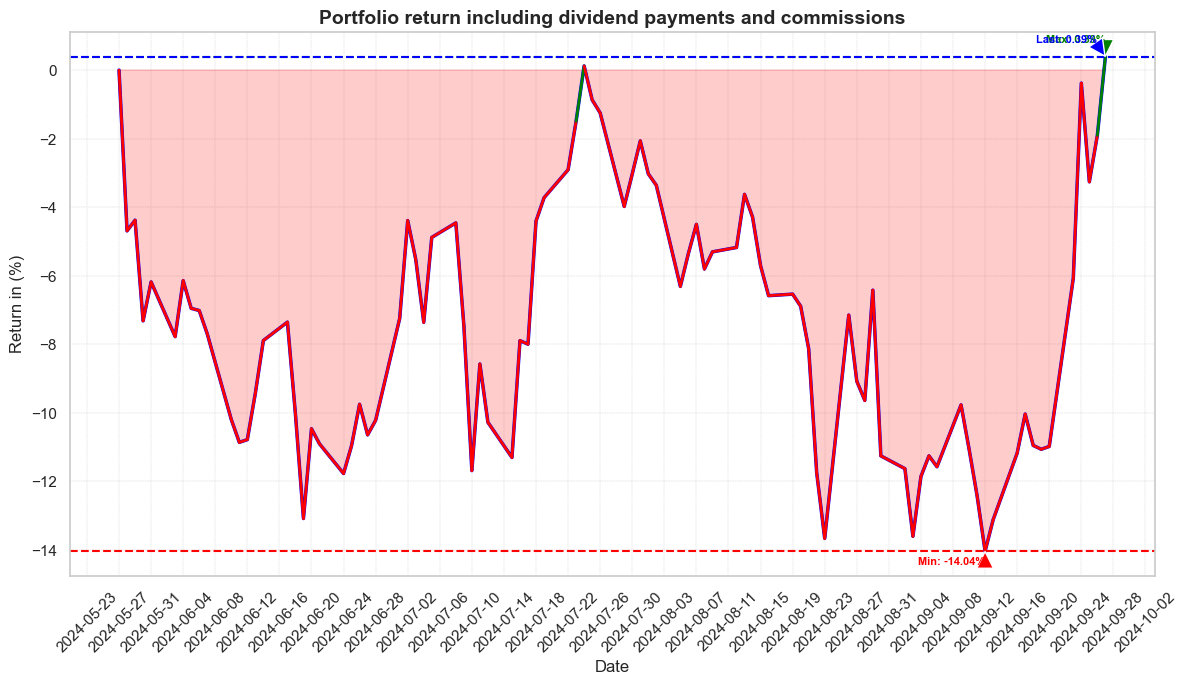

final_value 444563.5
total_out 0.0
initial_value 343716.999
total_in 99136.98


1709.521000000008

In [6]:
###################Portfolio returns###########################################################

rep_date = '2024-09-27'
returns = ComputeReturn('D:\\MoexTrading\\MoexData.db')
return_per_date = returns.get_portfolio_return_from_start(rep_date)
returns.plot_returns(return_per_date)
returns.get_rub_financial_result(rep_date,'YES')